# Лабораторная работа №4 по теме "Байесовские сети"

```
Студент: Леу Иван Александрович
Группа: М8О-309Б-23
Датасет: Mushroom Classification
```

### 0. Установка зависимостей

In [49]:
!pip install pgmpy networkx matplotlib pandas kagglehub

### 1.Импортируем библиотеки

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import CategoricalNB
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator, HillClimbSearch
from pgmpy.estimators import BIC as BicScore
from sklearn.preprocessing import LabelEncoder

from pgmpy.inference import VariableElimination
import warnings
import time
import pickle
import os
warnings.filterwarnings('ignore')

### 1. Загружаем датасет

In [51]:
import pandas as pd
pd.set_option('display.max_columns', 200)

mushrooms = pd.read_csv('mushrooms.csv')     
#classes = mushrooms['class'] 

Посмотрим на его структуру

In [52]:
print("mushrooms shape:", mushrooms.shape)
print(mushrooms.head())

#print("\nclasses:\n", classes.head())

mushrooms shape: (8124, 23)
  class cap-shape cap-surface cap-color bruises odor gill-attachment  \
0     p         x           s         n       t    p               f   
1     e         x           s         y       t    a               f   
2     e         b           s         w       t    l               f   
3     p         x           y         w       t    p               f   
4     e         x           s         g       f    n               f   

  gill-spacing gill-size gill-color stalk-shape stalk-root  \
0            c         n          k           e          e   
1            c         b          k           e          c   
2            c         b          n           e          c   
3            c         n          n           e          e   
4            w         b          k           t          e   

  stalk-surface-above-ring stalk-surface-below-ring stalk-color-above-ring  \
0                        s                        s                      w   
1         

### 2. Обработка датасета

Мы хотим использовать дискретные признаки; mushrooms уже дискретен. Сохраним колонки признаков и целевой class_type. Также уберем пропуски

In [53]:
if 'stalk-root' in mushrooms.columns:
    if mushrooms['stalk-root'].dtype == 'object':
        mushrooms['stalk-root'] = mushrooms['stalk-root'].replace('?', 'b')
        print(f"\nОбработаны пропущенные значения в 'stalk-root'. Новое распределение:")
        print(mushrooms['stalk-root'].value_counts().head())

mushrooms.columns.tolist()


Обработаны пропущенные значения в 'stalk-root'. Новое распределение:
stalk-root
b    6256
e    1120
c     556
r     192
Name: count, dtype: int64


['class',
 'cap-shape',
 'cap-surface',
 'cap-color',
 'bruises',
 'odor',
 'gill-attachment',
 'gill-spacing',
 'gill-size',
 'gill-color',
 'stalk-shape',
 'stalk-root',
 'stalk-surface-above-ring',
 'stalk-surface-below-ring',
 'stalk-color-above-ring',
 'stalk-color-below-ring',
 'veil-type',
 'veil-color',
 'ring-number',
 'ring-type',
 'spore-print-color',
 'population',
 'habitat']

In [54]:
target_col = 'class'

features = [c for c in mushrooms.columns if c != target_col]
print("Features:", features)
print("Target:", target_col)
print(mushrooms[target_col].value_counts())

Features: ['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']
Target: class
class
e    4208
p    3916
Name: count, dtype: int64


### 3. Построение Байесовской сети

Данный метод представляет собой конструктивное построение структуры дискретной байесовской сети путем явного задания направленных ребер между узлами. В этом подходе структура сети создается декларативно - мы напрямую указываем список кортежей (родительский узел, дочерний узел), что определяет направленные зависимости между переменными.

В Mushrooms логично, что признаки указывают на class (наивная структура: все признаки → класс). Это похож на наивный байес, но в байесовской сети можно добавить связи между некоторыми признаками.

In [ ]:
from pgmpy.models import DiscreteBayesianNetwork

edges = [(target_col, feat) for feat in features]
model_manual = DiscreteBayesianNetwork(edges)
print(list(model_manual.edges()))

[('class', 'cap-shape'), ('class', 'cap-surface'), ('class', 'cap-color'), ('class', 'bruises'), ('class', 'odor'), ('class', 'gill-attachment'), ('class', 'gill-spacing'), ('class', 'gill-size'), ('class', 'gill-color'), ('class', 'stalk-shape'), ('class', 'stalk-root'), ('class', 'stalk-surface-above-ring'), ('class', 'stalk-surface-below-ring'), ('class', 'stalk-color-above-ring'), ('class', 'stalk-color-below-ring'), ('class', 'veil-type'), ('class', 'veil-color'), ('class', 'ring-number'), ('class', 'ring-type'), ('class', 'spore-print-color'), ('class', 'population'), ('class', 'habitat')]


### 3. Получение вероятностей

Мы хотим получить вероятностные оценки переходов из одного состояние в другое. Для этого необходимо Байесовскую сеть подогнать по данные и получить таблички (CPT).

Conditional Probability Table (CPT) [Таблица Условных Вероятностей (CPT)] — это ключевой элемент, определяющий параметры Байесовской сети.

* Что это: Это таблица, которая содержит вероятность каждого возможного состояния узла (переменной) при условии всех возможных комбинаций состояний его родительских узлов (тех, от которых к нему идут стрелки/ребра).
* Роль: CPTs количественно определяют зависимости и силу связей между переменными, позволяя сети выполнять логический вывод и прогнозирование.
* Простой пример: В CPT для узла "Кашель", родительским узлом которого является "Грипп", будет указана вероятность кашля, если грипп есть (например, 90%), и вероятность кашля, если гриппа нет (например, 5%).

In [56]:
mushrooms_disc = mushrooms.copy()

label_encoders = {}

for c in mushrooms_disc.columns:
    le = LabelEncoder()
    mushrooms_disc[c] = le.fit_transform(mushrooms_disc[c])
    label_encoders[c] = le

print("Данные после преобразования:")
print(mushrooms_disc.head())
print("\nТипы данных:")
print(mushrooms_disc.dtypes)

model_manual.fit(mushrooms_disc, estimator=MaximumLikelihoodEstimator)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'class': 'N', 'cap-shape': 'N', 'cap-surface': 'N', 'cap-color': 'N', 'bruises': 'N', 'odor': 'N', 'gill-attachment': 'N', 'gill-spacing': 'N', 'gill-size': 'N', 'gill-color': 'N', 'stalk-shape': 'N', 'stalk-root': 'N', 'stalk-surface-above-ring': 'N', 'stalk-surface-below-ring': 'N', 'stalk-color-above-ring': 'N', 'stalk-color-below-ring': 'N', 'veil-type': 'N', 'veil-color': 'N', 'ring-number': 'N', 'ring-type': 'N', 'spore-print-color': 'N', 'population': 'N', 'habitat': 'N'}


Данные после преобразования:
   class  cap-shape  cap-surface  cap-color  bruises  odor  gill-attachment  \
0      1          5            2          4        1     6                1   
1      0          5            2          9        1     0                1   
2      0          0            2          8        1     3                1   
3      1          5            3          8        1     6                1   
4      0          5            2          3        0     5                1   

   gill-spacing  gill-size  gill-color  stalk-shape  stalk-root  \
0             0          1           4            0           2   
1             0          0           4            0           1   
2             0          0           5            0           1   
3             0          1           5            0           2   
4             1          0           4            1           2   

   stalk-surface-above-ring  stalk-surface-below-ring  stalk-color-above-ring  \
0           

Просмотр полной таблички

In [57]:
cpt_class = model_manual.get_cpds(target_col)
print("CPT for target/class:")
print(cpt_class)

CPT for target/class:
+----------+----------+
| class(0) | 0.517971 |
+----------+----------+
| class(1) | 0.482029 |
+----------+----------+


Посмотрим CPT для пары признаков (например odor, cap-color)

In [58]:
for node in ['odor','cap-color'] if 'odor' in features and 'cap-color' in features else features[:2]:
    print(f"\nCPT for {node}:")
    print(model_manual.get_cpds(node))


CPT for odor:
+---------+---------------------+----------------------+
| class   | class(0)            | class(1)             |
+---------+---------------------+----------------------+
| odor(0) | 0.09505703422053231 | 0.0                  |
+---------+---------------------+----------------------+
| odor(1) | 0.0                 | 0.049029622063329927 |
+---------+---------------------+----------------------+
| odor(2) | 0.0                 | 0.5515832482124617   |
+---------+---------------------+----------------------+
| odor(3) | 0.09505703422053231 | 0.0                  |
+---------+---------------------+----------------------+
| odor(4) | 0.0                 | 0.009193054136874362 |
+---------+---------------------+----------------------+
| odor(5) | 0.8098859315589354  | 0.030643513789581207 |
+---------+---------------------+----------------------+
| odor(6) | 0.0                 | 0.06537282941777324  |
+---------+---------------------+----------------------+
| odor(7) | 0.0 

### 4. Визуализация сети через библиотеку `networkx`

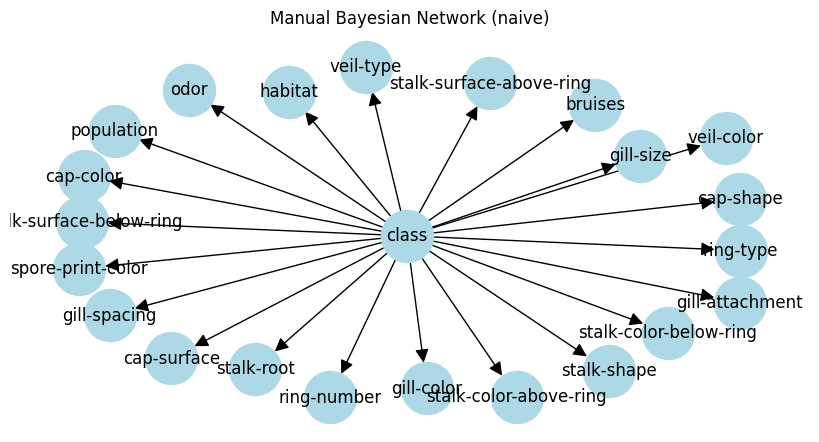

In [59]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_bn(model, title="Bayesian Network"):
    nx_graph = nx.DiGraph(model.edges())
    pos = nx.spring_layout(nx_graph, k=0.8, seed=42)
    plt.figure(figsize=(8,4))
    nx.draw(nx_graph, pos, with_labels=True, node_size=1400, node_color='lightblue', arrowsize=20)
    plt.title(title)
    plt.show()

plot_bn(model_manual, title="Manual Bayesian Network (naive)")

### 5. Посмотрим пример инференса

In [62]:
from pgmpy.inference import VariableElimination

infer = VariableElimination(model_manual)
q = infer.query(variables=[target_col], evidence={'odor': 0})
print(q)

+----------+--------------+
| class    |   phi(class) |
+==========+==============+
| class(0) |       1.0000 |
+----------+--------------+
| class(1) |       0.0000 |
+----------+--------------+


### 6. Сравнение байесовской сети с baseline-моделью (наивный Байес, CategoricalNB) по метрикам accuracy и log-loss

In [61]:
X = mushrooms_disc.drop(columns=[target_col])
y = mushrooms_disc[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

state_names = cpt_class.state_names[target_col]
state_labels = [int(s) for s in state_names]      
unique_labels = sorted(mushrooms_disc[target_col].unique())

probs_bn = []
preds_bn = []
for _, row in X_test.iterrows():
    evidence = row.to_dict()
    q = infer.query(variables=[target_col], evidence=evidence)
    dist = q.values
    prob_map = {lab: p for lab,p in zip(state_labels, dist)}
    probs_ordered = [prob_map.get(lbl, 0.0) for lbl in unique_labels]
    probs_bn.append(probs_ordered)
    preds_bn.append(unique_labels[int(np.argmax(probs_ordered))])

from sklearn.metrics import accuracy_score, log_loss
print("BN accuracy:", accuracy_score(y_test, preds_bn))
print("BN log_loss:", log_loss(y_test, probs_bn, labels=unique_labels))


from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import accuracy_score, log_loss

nb = CategoricalNB()
nb.fit(X_train, y_train)

preds_nb = nb.predict(X_test)
probs_nb = nb.predict_proba(X_test)

print('----------------------------------')
print("NB accuracy:", accuracy_score(y_test, preds_nb))
print("NB log_loss:", log_loss(y_test, probs_nb))

BN accuracy: 0.9950769230769231
BN log_loss: 0.007192322651623833
----------------------------------
NB accuracy: 0.9507692307692308
NB log_loss: 0.1336279988288641


## 7. Выводы

В ходе лабораторной работы была построена и проанализирована байесовская сеть для данных Mushrooms. Сначала данные были дискретизированы и подготовлены, затем создана структура сети по схеме «класс → признаки», что соответствует наивной байесовской модели. Для сети были получены таблицы условных вероятностей (CPT), показывающие, как каждый признак распределён в зависимости от класса животного.

Далее выполнен инференс: для каждой строки тестовой выборки сеть вычисляла вероятности классов, после чего были рассчитаны метрики качества. Байесовская сеть показала accuracy = 0.99 и практически нулевой log-loss, что говорит о точной вероятностной модели и корректной структуре сети для данного набора данных.

В целом работа продемонстрировала, что байесовские сети эффективно моделируют вероятностные зависимости и позволяют получать интерпретируемые выводы о данных.